<a href="https://colab.research.google.com/github/coolkite/machine_translation/blob/main/English%20To%20Spanish/%20English%20To%20Spanish%20Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip "/content/English to Spanish.zip"

Archive:  /content/English to Spanish.zip
  inflating: engToSpaFin.h5          
  inflating: __MACOSX/._engToSpaFin.h5  
  inflating: engTokenizer.pickle     
  inflating: __MACOSX/._engTokenizer.pickle  
  inflating: spaTokenizer.pickle     
  inflating: __MACOSX/._spaTokenizer.pickle  
  inflating: spa.txt                 
  inflating: __MACOSX/._spa.txt      


In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.preprocessing import *
from keras.models import Model, load_model
from keras.layers import *
from keras.utils import *
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
model = load_model("/content/engToSpaFin.h5")

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 72)]         0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 72, 300)      4289400     ['input_14[0][0]']               
                                                                                                  
 input_15 (InputLayer)          [(None, 70)]         0           []                               
                                                                                                  
 gru_21 (GRU)                   [(None, 72, 300),    541800      ['embedding_13[0][0]']           
                                 (None, 300)]                                               

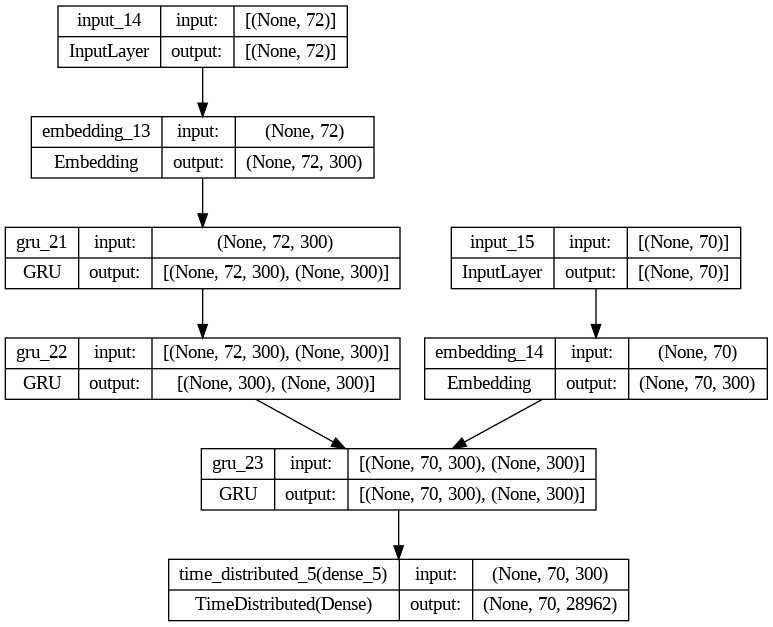

In [ ]:
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 72)]         0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 72, 300)      4289400     ['input_14[0][0]']               
                                                                                                  
 gru_21 (GRU)                   [(None, 72, 300),    541800      ['embedding_13[1][0]']           
                                 (None, 300)]                                                     
                                                                                                  
 gru_22 (GRU)                   [(None, 300),        541800      ['gru_21[1][0]',          

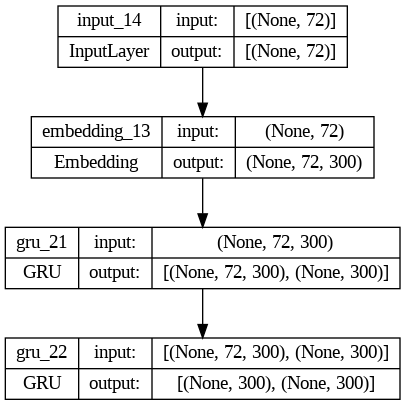

In [ ]:
encoder_input = model.input[0]
encoder_embedding = model.layers[1](encoder_input)
mid_encoder_layer = model.layers[3](encoder_embedding)
encoder_output, encoder_hidden = model.layers[5](mid_encoder_layer)
encoder_model = Model(encoder_input, encoder_hidden)
encoder_model.summary()
plot_model(encoder_model, to_file='enc_model.png', show_shapes=True)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 70)]         0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 70, 300)      8688900     ['input_15[0][0]']               
                                                                                                  
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 gru_23 (GRU)                   [(None, 70, 300),    541800      ['embedding_14[1][0]',           
                                 (None, 300)]                     'input_3[0][0]']         

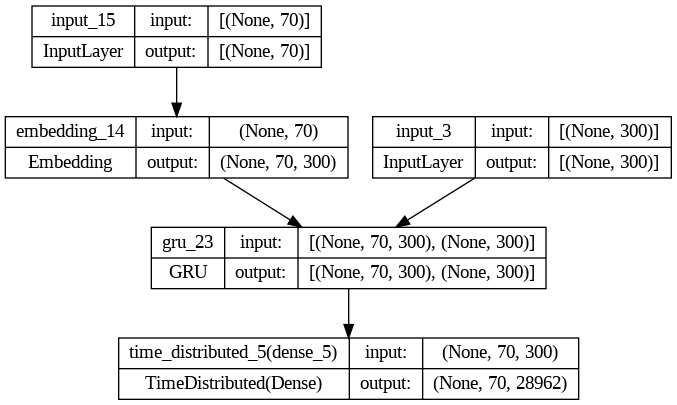

In [ ]:
decoder_input = model.inputs[1]
initial_decoder_state = Input(shape=(300,), name='input_3')
decoder_embedding = model.layers[4](decoder_input)
decoder_output, dec_hid_state = model.layers[6](decoder_embedding, initial_state = initial_decoder_state)
decoder_dense = model.layers[7](decoder_output)

decoder_model = Model([decoder_input] + [initial_decoder_state], [decoder_dense] + [dec_hid_state])
decoder_model.summary()
plot_model(decoder_model, to_file='dec_model.png', show_shapes=True)

In [ ]:
from tensorflow.python.ops.gen_array_ops import reverse
import pickle
with open('/content/engTokenizer.pickle', 'rb') as handle:
    eng_dict = pickle.load(handle)
with open('/content/spaTokenizer.pickle', 'rb') as handle:
    spa_dict = pickle.load(handle)
reverse_spa_dict = {value:key for key, value in spa_dict.items()}
print(eng_dict)
print(spa_dict)
print(reverse_spa_dict)

{'bos': 1, 'eos': 2, 'i': 3, 'the': 4, 'to': 5, 'you': 6, 'tom': 7, 'a': 8, 'is': 9, 'he': 10, 'in': 11, 'that': 12, 'of': 13, 'it': 14, 'do': 15, 'was': 16, 'me': 17, 'this': 18, 'have': 19, 'my': 20, "don't": 21, 'for': 22, 'are': 23, 'what': 24, 'your': 25, 'we': 26, 'she': 27, "i'm": 28, 'mary': 29, 'be': 30, 'his': 31, 'on': 32, 'want': 33, 'with': 34, 'not': 35, 'like': 36, 'and': 37, 'know': 38, 'at': 39, 'can': 40, 'go': 41, 'him': 42, "it's": 43, 'has': 44, 'how': 45, 'there': 46, 'did': 47, 'her': 48, 'time': 49, 'as': 50, 'very': 51, 'they': 52, 'all': 53, 'here': 54, 'will': 55, "didn't": 56, 'about': 57, 'think': 58, 'had': 59, 'up': 60, 'get': 61, "can't": 62, 'out': 63, 'if': 64, 'one': 65, 'when': 66, 'going': 67, "you're": 68, 'no': 69, 'an': 70, 'from': 71, 'why': 72, 'were': 73, "doesn't": 74, 'good': 75, 'see': 76, "i'll": 77, 'need': 78, 'by': 79, 'come': 80, 'who': 81, 'would': 82, 'please': 83, 'just': 84, 'so': 85, 'been': 86, 'help': 87, 'more': 88, 'now': 89, 

In [ ]:
def tokenize(sentence, word_index):
  import re
  sentence = "<BOS> " + sentence + " <EOS>"
  sentence = sentence.lower()
  sentence = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", sentence)
  sentence = sentence.split(sep=" ")
  temp = sentence
  sentence = [word for word in temp if word != '']
  sentence = list(map(lambda key: word_index[key], sentence))
  return sentence, word_index

def padding(sentence, max_length):
  sentence = np.array(sentence)
  sentence = sentence.reshape(1,sentence.shape[0])
  sentence = pad_sequences(sentence, maxlen=max_length, padding = 'post', truncating = 'post')
  return sentence

In [ ]:
eng_max_length = 72
spa_max_length = 70

def translate(orig_sentence):
  sentence, dic = tokenize(orig_sentence, eng_dict)
  sentence = padding(sentence, eng_max_length)

  enc_vector = encoder_model.predict(sentence, verbose=0)

  prev_word = np.zeros((1,1))
  prev_word[0,0] = spa_dict["bos"]
  trans_seq = []

  while True:
    output_token, last_hidden = decoder_model.predict([prev_word]+[enc_vector], verbose=0)
    pred_token = np.argmax(output_token[0,:])
    word = reverse_spa_dict[pred_token]

    enc_vector = last_hidden
    prev_word[0,0] = pred_token

    if word == "eos":
      break

    trans_seq.append(word)

  translation = " ".join(trans_seq)
  return translation

In [ ]:
orig_sentence = "I want to play outside with my girlfriend."
translation = translate(orig_sentence)
print("Original english sentence: " + orig_sentence)
print("Translated spanish sentence: " + translation)

Original english sentence: I want to play outside with my girlfriend.
Translated spanish sentence: quiero jugar con mi pieza
